In [2]:
import glob 
import os

import numpy as np
from astropy.io import fits
import poppy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline


In [ ]:
def display_profiles(HDUlist_or_filename=None, ext=0, overplot=False, title=None, vmin=1e-8, vmax=1e-2, **kwargs):
    """ Produce two plots of PSF radial profile and encircled energy

    !!! Taken directly from Poppy !!!

    See also the display_ee function.

    Parameters
    ----------
    HDUlist_or_filename1,2 : fits.HDUlist or string
        FITS files containing image to difference
    ext : bool
        FITS extension to use. Default is 0
    overplot : bool
        whether to overplot or clear and produce an new plot. Default false
    title : string, optional
        Title for plot

    """
    if isinstance(HDUlist_or_filename, str):
        hdu_list = fits.open(HDUlist_or_filename, ext=ext)
    elif isinstance(HDUlist_or_filename, fits.HDUList):
        hdu_list = HDUlist_or_filename
    else:
        raise ValueError("input must be a filename or HDUlist")

    radius, profile, ee = poppy.radial_profile(hdu_list, ee=True, ext=ext, **kwargs)

    plt.semilogy(radius, profile)
    
    plt.xlabel("Radius [arcsec]")
    plt.ylabel("PSF radial profile")
    plt.xlim(0, 1)
    plt.ylim(vmin, vmax)
    
    plt.twinx()
    
    plt.plot(radius, ee, color='r')
    
    fwhm = 2 * radius[np.where(profile < profile[0] * 0.5)[0][0]]
    plt.text(fwhm, profile[0] * 0.5, 'FWHM = %.3f"' % fwhm)
    
    plt.xlabel("Radius [arcsec]")
    plt.ylabel("Encircled Energy")

    for level in [0.5, 0.8, 0.95]:
        if (ee > level).any():
            ee_lev = radius[np.where(ee > level)[0][0]]
            yoffset = 0 if level < 0.9 else -0.05
            plt.text(ee_lev + 0.1, level + yoffset, 'EE=%2d%% at r=%.3f"' % (level * 100, ee_lev))


In [3]:
psf_list = glob.glob("C:/Work/irdb/_PSFs/*.fits")
psf_list

['C:/Work/irdb/_PSFs\\AnisoCADO_SCAO_FVPSF_4mas_1024_20190321.fits',
 'C:/Work/irdb/_PSFs\\Default_PSF_POPPY.fits',
 'C:/Work/irdb/_PSFs\\Default_PSF_SCAO.fits',
 'C:/Work/irdb/_PSFs\\MAORY_MCAO_CONSTPSF_1.5mas.fits',
 'C:/Work/irdb/_PSFs\\MAORY_MCAO_CONSTPSF_4mas.fits',
 'C:/Work/irdb/_PSFs\\MAORY_MCAO_FVPSF_1.5mas_20181203.fits',
 'C:/Work/irdb/_PSFs\\MAORY_MCAO_FVPSF_4mas_20181203.fits',
 'C:/Work/irdb/_PSFs\\MAORY_SCAO_CONST_PSF_1.5mas.fits',
 'C:/Work/irdb/_PSFs\\MAORY_SCAO_CONST_PSF_4mas.fits',
 'C:/Work/irdb/_PSFs\\MAORY_SCAO_FVPSF_1.5mas_20181203.fits',
 'C:/Work/irdb/_PSFs\\MAORY_SCAO_FVPSF_4mas_20181203.fits']

(1024, 1024)


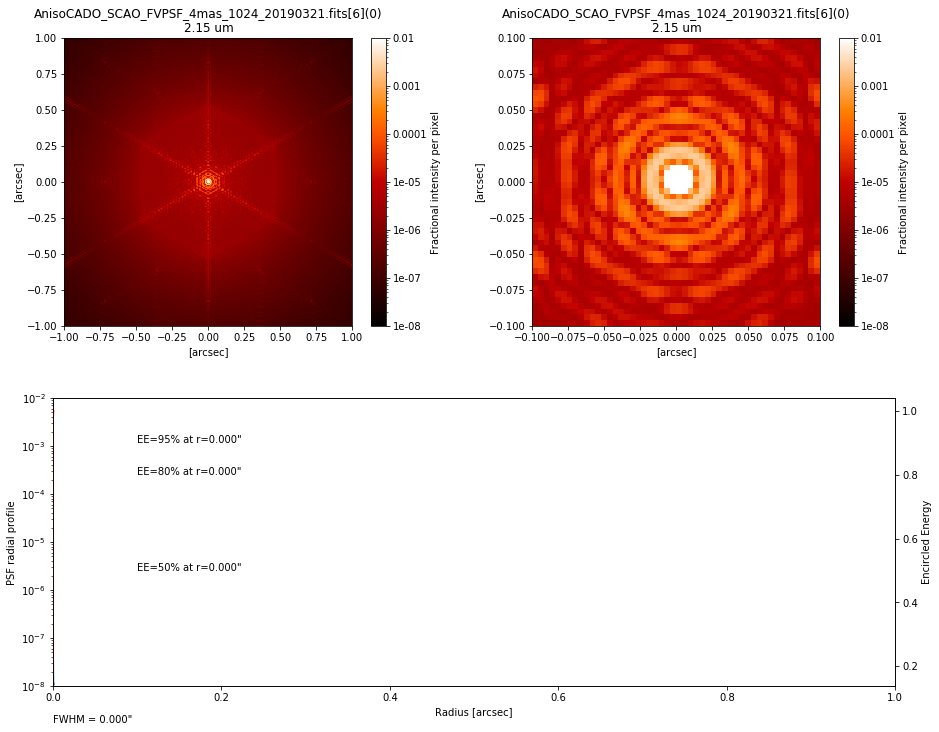

In [6]:
file_ii = 0
ext_ii = 6
slice_ii = 0

psf_file = psf_list[file_ii]

with fits.open(psf_file) as hdulist:
    hdu = hdulist[ext_ii]
    if len(hdu.data.shape) == 3:
        data = hdu.data[slice_ii, :, :]
    else:
        data = hdu.data
    print(data.shape)
    prihdu = fits.PrimaryHDU(header=hdu.header, data=data)
    if "deg" in prihdu.header["CUNIT1"]:
        prihdu.header["CDELT1"] *= 3600
        prihdu.header["CDELT2"] *= 3600
        prihdu.header["CUNIT1"] = "arcsec"
        prihdu.header["CUNIT2"] = "arcsec"
    
    hdulist = fits.HDUList([prihdu])
                             
wave = hdulist[0].header["WAVE0"]
title = "{}[{}]({})\n{} um".format(os.path.basename(psf_file), ext_ii, slice_ii, wave)

params = {"HDUlist_or_filename": hdulist, 
          "pixelscale": "CDELT1", 
          "interpolation": "none",
          "normalize": "total",
          "title": title,
          "vmax": 1e-2,
          "vmin": 1e-8}

plt.figure(figsize=(13,10))

plt.axes([0.05, 0.55, 0.4, 0.4])
poppy.display_psf(**params, imagecrop=2)
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")

plt.axes([0.55, 0.55, 0.4, 0.4])
poppy.display_psf(**params, imagecrop=0.2)
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")

plt.axes([0.05, 0.05, 0.9, 0.4])
display_profiles(hdulist, title=title, vmin=params["vmin"], vmax=params["vmax"])
